#시작하기

##데이터 작업하기

파이토치(PyTorch)에는 데이터 작업을 위한 기본 요소 두가지인 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 가 있습니다. Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 순회 가능한 객체(iterable)로 감쌉니다.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch는 TorchText, TorchVision 및 TorchAudio 와 같이 도메인 특화 라이브러리를 데이터셋과 함께 제공하고 있습니다. 이 튜토리얼에서는 TorchVision 데이터셋을 사용하도록 하겠습니다.

torchvision.datasets 모듈은 CIFAR, COCO 등과 같은 다양한 실제 비전(vision) 데이터에 대한 Dataset(전체 목록은 여기)을 포함하고 있습니다. 이 튜토리얼에서는 FasionMNIST 데이터셋을 사용합니다. 모든 TorchVision Dataset 은 샘플과 정답을 각각 변경하기 위한 transform 과 target_transform 의 두 인자를 포함합니다.

In [2]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Dataset 을 DataLoader 의 인자로 전달합니다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다. 여기서는 배치 크기(batch size)를 64로 정의합니다. 즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.

In [3]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


##모델 만들기

PyTorch에서 신경망 모델은 nn.Module 을 상속받는 클래스(class)를 생성하여 정의합니다. __init__ 함수에서 신경망의 계층(layer)들을 정의하고 forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정합니다. 가능한 경우 GPU로 신경망을 이동시켜 연산을 가속(accelerate)합니다.

In [4]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 모델 매개변수 최적화하기

모델을 학습하려면 손실 함수(loss function) 와 옵티마이저(optimizer) 가 필요합니다.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

각 학습 단계(training loop)에서 모델은 (배치(batch)로 제공되는) 학습 데이터셋에 대한 예측을 수행하고, 예측 오류를 역전파하여 모델의 매개변수를 조정합니다.

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인합니다.

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

학습 단계는 여러번의 반복 단계 (에폭(epochs)) 를 거쳐서 수행됩니다. 각 에폭에서는 모델은 더 나은 예측을 하기 위해 매개변수를 학습합니다. 각 에폭마다 모델의 정확도(accuracy)와 손실(loss)을 출력합니다; 에폭마다 정확도가 증가하고 손실이 감소하는 것을 보려고 합니다.

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310421  [    0/60000]
loss: 2.290626  [ 6400/60000]
loss: 2.268998  [12800/60000]
loss: 2.255613  [19200/60000]
loss: 2.252069  [25600/60000]
loss: 2.217764  [32000/60000]
loss: 2.227466  [38400/60000]
loss: 2.196462  [44800/60000]
loss: 2.189983  [51200/60000]
loss: 2.158144  [57600/60000]
Test Error: 
 Accuracy: 48.5%, Avg loss: 2.152008 

Epoch 2
-------------------------------
loss: 2.166844  [    0/60000]
loss: 2.154224  [ 6400/60000]
loss: 2.091328  [12800/60000]
loss: 2.105316  [19200/60000]
loss: 2.067991  [25600/60000]
loss: 2.003530  [32000/60000]
loss: 2.038417  [38400/60000]
loss: 1.957303  [44800/60000]
loss: 1.952385  [51200/60000]
loss: 1.899278  [57600/60000]
Test Error: 
 Accuracy: 57.5%, Avg loss: 1.887354 

Epoch 3
-------------------------------
loss: 1.918278  [    0/60000]
loss: 1.894812  [ 6400/60000]
loss: 1.769280  [12800/60000]
loss: 1.810830  [19200/60000]
loss: 1.727793  [25600/60000]
loss: 1.665569  [32000/600

##모델 저장하기

모델을 저장하는 일반적인 방법은 (모델의 매개변수들을 포함하여) 내부 상태 사전(internal state dictionary)을 직렬화(serialize)하는 것입니다.

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


##모델 불러오기

모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함됩니다.

In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

이제 이 모델을 사용해서 예측을 할 수 있습니다.

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#텐서(TENSOR)

텐서(tensor)는 배열(array)이나 행렬(matrix)과 매우 유사한 특수한 자료구조입니다. PyTorch에서는 텐서를 사용하여 모델의 입력(input)과 출력(output), 그리고 모델의 매개변수들을 부호화(encode)합니다.

텐서는 GPU나 다른 하드웨어 가속기에서 실행할 수 있다는 점만 제외하면 NumPy 의 ndarray와 유사합니다. 실제로 텐서와 NumPy 배열(array)은 종종 동일한 내부(underly) 메모리를 공유할 수 있어 데이터를 복수할 필요가 없습니다. (NumPy 변환(Bridge) 참고) 텐서는 또한 (Autograd 장에서 살펴볼) 자동 미분(automatic differentiation)에 최적화되어 있습니다.

In [13]:
import torch
import numpy as np

##텐서(tensor) 초기화

텐서는 여러가지 방법으로 초기화할 수 있습니다

###데이터로부터 직접(directly) 생성하기

데이터로부터 직접 텐서를 생성할 수 있습니다. 데이터의 자료형(data type)은 자동으로 유추합니다.

In [14]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

###NumPy 배열로부터 생성하기

텐서는 NumPy 배열로 생성할 수 있습니다. (그 반대도 가능합니다 - NumPy 변환(Bridge) 참고)

In [15]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

###다른 텐서로부터 생성하기:

명시적으로 재정의(override)하지 않는다면, 인자로 주어진 텐서의 속성(모양(shape), 자료형(datatype))을 유지합니다.

In [17]:
x_ones = torch.ones_like(x_data) # x_data의 속성을 유지합니다.
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # x_data의 속성을 덮어씁니다.
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8845, 0.9861],
        [0.6022, 0.8096]]) 



###무작위(random) 또는 상수(constant) 값을 사용하기:

shape 은 텐서의 차원(dimension)을 나타내는 튜플(tuple)로, 아래 함수들에서는 출력 텐서의 차원을 결정합니다.

In [18]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.2685, 0.7724, 0.1661],
        [0.6397, 0.5331, 0.4432]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


##텐서의 속성(Attribute)

텐서의 속성은 텐서의 모양(shape), 자료형(datatype) 및 어느 장치에 저장되는지를 나타냅니다.

In [21]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


##텐서 연산(Operation)

전치(transposing), 인덱싱(indexing), 슬라이싱(slicing), 수학 계산, 선형 대수, 임의 샘플링(random sampling) 등, 100가지 이상의 텐서 연산들을 여기 에서 확인할 수 있습니다.

각 연산들은 (일반적으로 CPU보다 빠른) GPU에서 실행할 수 있습니다. Colab을 사용한다면, Edit > Notebook Settings 에서 GPU를 할당할 수 있습니다.

기본적으로 텐서는 CPU에 생성됩니다. .to 메소드를 사용하면 (GPU의 가용성(availability)을 확인한 뒤) GPU로 텐서를 명시적으로 이동할 수 있습니다. 장치들 간에 큰 텐서들을 복사하는 것은 시간과 메모리 측면에서 비용이 많이든다는 것을 기억하세요!

In [19]:
# GPU가 존재하면 텐서를 이동합니다
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

목록에서 몇몇 연산들을 시도해보세요. NumPy API에 익숙하다면 Tensor API를 사용하는 것은 식은 죽 먹기라는 것을 알게 되실 겁니다.

### NumPy식의 표준 인덱싱과 슬라이싱:

In [20]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


##NumPy 변환(Bridge)

CPU 상의 텐서와 NumPy 배열은 메모리 공간을 공유하기 때문에, 하나를 변경하면 다른 하나도 변경됩니다.

### 텐서를 NumPy 배열로 변환하기

In [22]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


텐서의 변경 사항이 NumPy 배열에 반영됩니다.

In [23]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


### NumPy 배열을 텐서로 변환하기

In [24]:
n = np.ones(5)
t = torch.from_numpy(n)

NumPy 배열의 변경 사항이 텐서에 반영됩니다.

In [25]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


#DATASET과 DATALOADER

데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어려울 수 있습니다; 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다. PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다. Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.

PyTorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 미리 준비해둔(pre-loaded) 다양한 데이터셋을 제공합니다. 데이터셋은 torch.utils.data.Dataset 의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있습니다. 이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark)하는데 사용할 수 있습니다.

##데이터셋 불러오기

TorchVision 에서 Fashion-MNIST 데이터셋을 불러오는 예제를 살펴보겠습니다. Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있습니다. 각 예제는 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성됩니다.

다음 매개변수들을 사용하여 FashionMNIST 데이터셋 을 불러옵니다:
*   root 는 학습/테스트 데이터가 저장되는 경로입니다.
*   train 은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.
*   download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드합니다.
*   transform 과 target_transform 은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.

In [26]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

##데이터셋을 순회하고 시각화하기



Dataset 에 리스트(list)처럼 직접 접근(index)할 수 있습니다: training_data[index]. matplotlib 을 사용하여 학습 데이터의 일부를 시각화해보겠습니다.

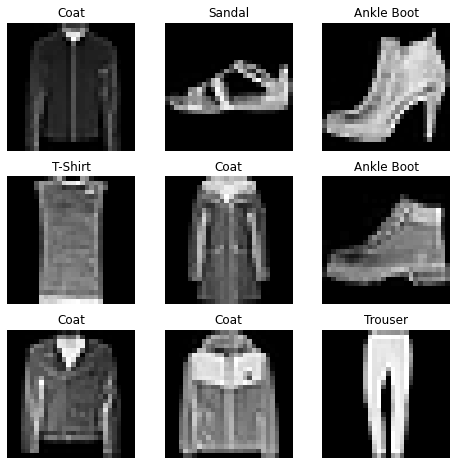

In [27]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

##파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: __init__, __len__, and __getitem__. 아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장됩니다.

다음 장에서 각 함수들에서 일어나는 일들을 자세히 살펴보겠습니다.

In [28]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

###`__init__`

`__init__ `함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두가지 변형(transform)을 초기화합니다.

labels.csv 파일은 다음과 같습니다:


```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```



In [29]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

###`__len__`

`__len__ `함수는 데이터셋의 샘플 개수를 반환합니다.

def __len__(self):
    return len(self.img_labels)

### `__getitem__`



`__getitem__` 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고, self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.

In [30]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

##DataLoader로 학습용 데이터 준비하기

Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다.

DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)입니다.

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

##DataLoader를 통해 순회하기(iterate)

DataLoader 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환합니다. shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다. (데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 Samplers 를 살펴보세요.)

In [32]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


Label: 9


#변형(TRANSFORM)

데이터가 항상 머신러닝 알고리즘 학습에 필요한 최종 처리가 된 형태로 제공되지는 않습니다. 변형(transform) 을 해서 데이터를 조작하고 학습에 적합하게 만듭니다.

모든 TorchVision 데이터셋들은 변형 로직을 갖는, 호출 가능한 객체(callable)를 받는 매개변수 두개 ( 특징(feature)을 변경하기 위한 transform 과 정답(label)을 변경하기 위한 target_transform )를 갖습니다 torchvision.transforms 모듈은 주로 사용하는 몇가지 변형(transform)을 제공합니다.

FashionMNIST 특징(feature)은 PIL Image 형식이며, 정답(label)은 정수(integer)입니다. 학습을 하려면 정규화(normalize)된 텐서 형태의 특징(feature)과 원-핫(one-hot)으로 부호화(encode)된 텐서 형태의 정답(label)이 필요합니다. 이러한 변형(transformation)을 하기 위해 ToTensor 와 Lambda 를 사용합니다.

In [33]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

##ToTensor()

ToTensor 는 PIL Image나 NumPy ndarray 를 FloatTensor 로 변환하고, 이미지의 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 조정(scale)합니다.

##Lambda 변형(Transform)

Lambda 변형은 사용자 정의 람다(lambda) 함수를 적용합니다. 여기에서는 정수를 원-핫으로 부호화된 텐서로 바꾸는 함수를 정의합니다. 이 함수는 먼저 (데이터셋 정답의 개수인) 크기 10짜리 영 텐서(zero tensor)를 만들고, scatter_ 를 호출하여 주어진 정답 y 에 해당하는 인덱스에 value=1 을 할당합니다.

In [34]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# 신경망 모델 구성하기

신경망은 데이터에 대한 연산을 수행하는 계층(layer)/모듈(module)로 구성되어 있습니다. torch.nn 네임스페이스는 신경망을 구성하는데 필요한 모든 구성 요소를 제공합니다. PyTorch의 모든 모듈은 nn.Module 의 하위 클래스(subclass) 입니다. 신경망은 다른 모듈(계층; layer)로 구성된 모듈입니다. 이러한 중첩된 구조는 복잡한 아키텍처를 쉽게 구축하고 관리할 수 있습니다.

이어지는 장에서는 FashionMNIST 데이터셋의 이미지들을 분류하는 신경망을 구성해보겠습니다.

In [35]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##학습을 위한 장치 얻기



가능한 경우 GPU와 같은 하드웨어 가속기에서 모델을 학습하려고 합니다. torch.cuda 를 사용할 수 있는지 확인하고 그렇지 않으면 CPU를 계속 사용합니다.

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


##클래스 정의하기

신경망 모델을 nn.Module 의 하위클래스로 정의하고, __init__ 에서 신경망 계층들을 초기화합니다. nn.Module 을 상속받은 모든 클래스는 forward 메소드에 입력 데이터에 대한 연산들을 구현합니다.

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

NeuralNetwork 의 인스턴스(instance)를 생성하고 이를 device 로 이동한 뒤, 구조(structure)를 출력합니다.

In [38]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


모델을 사용하기 위해 입력 데이터를 전달합니다. 이는 일부 백그라운드 연산들 과 함께 모델의 forward 를 실행합니다. model.forward() 를 직접 호출하지 마세요!

모델에 입력을 호출하면 각 분류(class)에 대한 원시(raw) 예측값이 있는 10-차원 텐서가 반환됩니다. 원시 예측값을 nn.Softmax 모듈의 인스턴스에 통과시켜 예측 확률을 얻습니다.

In [39]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


##모델 계층(Layer)



FashionMNIST 모델의 계층들을 살펴보겠습니다. 이를 설명하기 위해, 28x28 크기의 이미지 3개로 구성된 미니배치를 가져와, 신경망을 통과할 때 어떤 일이 발생하는지 알아보겠습니다.



In [40]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

nn.Flatten 계층을 초기화하여 각 28x28의 2D 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환합니다. (dim=0의 미니배치 차원은 유지됩니다.)

In [41]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

선형 계층 은 저장된 가중치(weight)와 편향(bias)을 사용하여 입력에 선형 변환(linear transformation)을 적용하는 모듈입니다.

In [42]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

비선형 활성화(activation)는 모델의 입력과 출력 사이에 복잡한 관계(mapping)를 만듭니다. 비선형 활성화는 선형 변환 후에 적용되어 비선형성(nonlinearity) 을 도입하고, 신경망이 다양한 현상을 학습할 수 있도록 돕습니다.

이 모델에서는 nn.ReLU 를 선형 계층들 사이에 사용하지만, 모델을 만들 때는 비선형성을 가진 다른 활성화를 도입할 수도 있습니다.

In [43]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.5043,  0.3842,  0.0646,  0.3567,  0.0566,  0.7367,  0.1868, -0.3184,
         -0.2520, -1.0061, -0.0480, -0.1423, -0.0696, -0.0904,  0.1866, -0.1147,
         -0.2703, -0.4424, -0.0442, -0.4017],
        [ 0.1919,  0.2271,  0.0674,  0.3536,  0.2390,  0.7857,  0.2114, -0.2297,
         -0.2517, -0.7977,  0.1620, -0.3606, -0.0087, -0.1389,  0.4664, -0.5425,
         -0.0257, -0.1974, -0.2899, -0.2962],
        [ 0.1159,  0.5809,  0.2756, -0.0295,  0.2503,  0.6895,  0.1333, -0.2561,
         -0.2989, -0.8430,  0.0955, -0.3012,  0.2168, -0.6983,  0.3571, -0.3414,
          0.0670, -0.2782, -0.0821, -0.4079]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.5043, 0.3842, 0.0646, 0.3567, 0.0566, 0.7367, 0.1868, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1866, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1919, 0.2271, 0.0674, 0.3536, 0.2390, 0.7857, 0.2114, 0.0000, 0.0000,
         0.0000, 0.1620, 0.0000, 0.0000, 0.0000, 0.46

### nn.Sequential

nn.Sequential 은 순서를 갖는 모듈의 컨테이너입니다. 데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달됩니다. 순차 컨테이너(sequential container)를 사용하여 아래의 seq_modules 와 같은 신경망을 빠르게 만들 수 있습니다.

In [44]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax



신경망의 마지막 선형 계층은 nn.Softmax 모듈에 전달될 ([-infty, infty] 범위의 원시 값(raw value)인) logits 를 반환합니다. logits는 모델의 각 분류(class)에 대한 예측 확률을 나타내도록 [0, 1] 범위로 비례하여 조정(scale)됩니다. dim 매개변수는 값의 합이 1이 되는 차원을 나타냅니다.

In [45]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

##모델 매개변수

신경망 내부의 많은 계층들은 매개변수화(parameterize) 됩니다. 즉, 학습 중에 최적화되는 가중치와 편향과 연관지어집니다. nn.Module 을 상속하면 모델 객체 내부의 모든 필드들이 자동으로 추적(track)되며, 모델의 parameters() 및 named_parameters() 메소드로 모든 매개변수에 접근할 수 있게 됩니다.

이 예제에서는 각 매개변수들을 순회하며(iterate), 매개변수의 크기와 값을 출력합니다.

In [46]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0274,  0.0197, -0.0287,  ...,  0.0272,  0.0057, -0.0181],
        [ 0.0012,  0.0123, -0.0101,  ..., -0.0329,  0.0254,  0.0075]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0329, -0.0329], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0095, -0.0082, -0.0173,  ..., -0.0248, -0.0113, -0.0222],
        [-0.0243, -0.0104, -0.0367,  ..., -0.0199, -0.0055,  0.0189]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# TORCH.AUTOGRAD를 사용한 자동 미분

신경망을 학습할 때 가장 자주 사용되는 알고리즘은 역전파입니다. 이 알고리즘에서, 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도(gradient)에 따라 조정됩니다.

이러한 변화도를 계산하기 위해 PyTorch에는 torch.autograd라고 불리는 자동 미분 엔진이 내장되어 있습니다. 이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원합니다.

입력 x, 매개변수 w와 b , 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층 신경망을 가정하겠습니다. PyTorch에서는 다음과 같이 정의할 수 있습니다:

In [48]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

### Tensor, Function과 연산그래프(Computational graph)

이 코드는 다음의 연산 그래프 를 정의합니다:
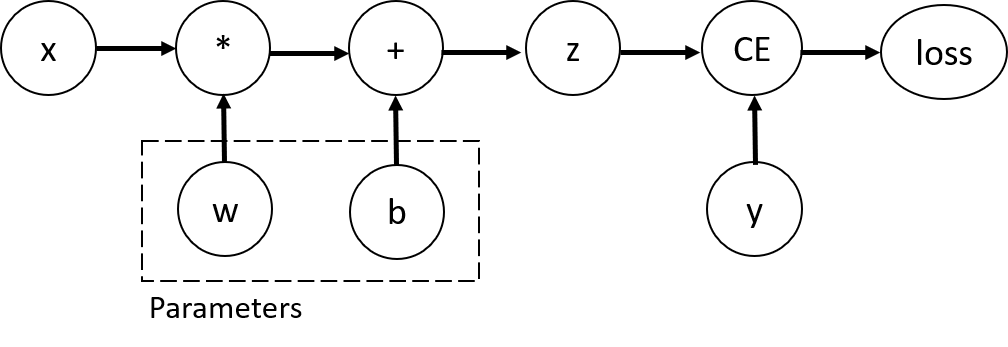
이 신경망에서, w와 b는 최적화를 해야 하는 매개변수입니다. 따라서 이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 합니다. 이를 위해서 해당 텐서에 requires_grad 속성을 설정합니다. <br>
<br>
+requires_grad의 값은 텐서를 생성할 때 설정하거나, 나중에 x.requires_grad_(True) 메소드를 사용하여 나중에 설정할 수도 있습니다.<br>
<br>
연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 Function 클래스의 객체입니다. 이 객체는 순전파 방향으로 함수를 계산하는 방법과, 역방향 전파 단계에서 도함수(derivative)를 계산하는 방법을 알고 있습니다. 역방향 전파 함수에 대한 참조(reference)는 텐서의 grad_fn 속성에 저장됩니다. Function에 대한 자세한 정보는 이 문서 에서 찾아볼 수 있습니다.

In [49]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f25817afc50>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f25817af210>


### 변화도(Gradient) 계산하기

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산해야 합니다. 즉, x와 y의 일부 고정값에서 
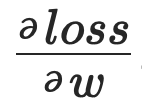
 와 
​	스크린샷 2022-11-10 오전 10.09.21.png
  가 필요합니다. 이러한 도함수를 계산하기 위해, loss.backward() 를 호출한 다음 w.grad와 b.grad에서 값을 가져옵니다:



In [50]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3202, 0.0864, 0.2691],
        [0.3202, 0.0864, 0.2691],
        [0.3202, 0.0864, 0.2691],
        [0.3202, 0.0864, 0.2691],
        [0.3202, 0.0864, 0.2691]])
tensor([0.3202, 0.0864, 0.2691])


+ <br>
*   연산 그래프의 잎(leaf) 노드들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가 유효하지 않습니다.
*   성능 상의 이유로, 주어진 그래프에서의 backward를 사용한 변화도 계산은 한 번만 수행할 수 있습니다. 만약 동일한 그래프에서 여러번의 backward 호출이 필요하면, backward 호출 시에 retrain_graph=True를 전달해야 합니다.

### 변화도 추적 멈추기

기본적으로, requires_grad=True인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원합니다. 그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는, 이러한 추적이나 지원이 필요 없을 수 있습니다. 연산 코드를 torch.no_grad() 블록으로 둘러싸서 연산 추적을 멈출 수 있습니다:

In [51]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


동일한 결과를 얻는 다른 방법은 텐서에 detach() 메소드를 사용하는 것입니다:

In [52]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


변화도 추적을 멈춰야 하는 이유들은 다음과 같습니다:
*   신경망의 일부 매개변수를 고정된 매개변수(frozen parameter)로 표시합니다. 이는 사전 학습된 신경망을 미세조정 할 때 매우 일반적인 시나리오입니다.
*   변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 연산 속도가 향상됩니다.


### 연산 그래프에 대한 추가 정보

개념적으로, autograd는 데이터(텐서)의 및 실행된 모든 연산들(및 연산 결과가 새로운 텐서인 경우도 포함하여)의 기록을 Function 객체로 구성된 방향성 비순환 그래프(DAG; Directed Acyclic Graph)에 저장(keep)합니다. 이 방향성 비순환 그래프(DAG)의 잎(leave)은 입력 텐서이고, 뿌리(root)는 결과 텐서입니다. 이 그래프를 뿌리에서부터 잎까지 추적하면 연쇄 법칙(chain rule)에 따라 변화도를 자동으로 계산할 수 있습니다.

순전파 단계에서, autograd는 다음 두 가지 작업을 동시에 수행합니다:



*   요청된 연산을 수행하여 결과 텐서를 계산하고,
*   DAG에 연산의 변화도 기능(gradient function) 를 유지(maintain)합니다.

역전파 단계는 DAG 뿌리(root)에서 .backward() 가 호출될 때 시작됩니다. autograd는 이 때:


*   각 .grad_fn 으로부터 변화도를 계산하고,
*   각 텐서의 .grad 속성에 계산 결과를 쌓고(accumulate),
*   연쇄 법칙을 사용하여, 모든 잎(leaf) 텐서들까지 전파(propagate)합니다.





PyTorch에서 DAG들은 동적(dynamic)입니다. 주목해야 할 중요한 점은 그래프가 처음부터(from scratch) 다시 생성된다는 것입니다; 매번 .bachward() 가 호출되고 나면, autograd는 새로운 그래프를 채우기(populate) 시작합니다. 이러한 점 덕분에 모델에서 흐름 제어(control flow) 구문들을 사용할 수 있게 되는 것입니다; 매번 반복(iteration)할 때마다 필요하면 모양(shape)이나 크기(size), 연산(operation)을 바꿀 수 있습니다.

### 선택적으로 읽기(Optional Reading): 텐서 변화도와 야코비안 곱 (Jacobian Product)

부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 합니다. 그러나 출력 함수가 임의의 텐서인 경우가 있습니다. 이럴 때, PyTorch는 실제 변화도가 아닌 야코비안 곱(Jacobian product)을 계산합니다.

x
⃗
=
⟨
x
1
,
…
,
x
n
⟩
x
 =⟨x 
1
​	
 ,…,x 
n
​	
 ⟩이고, 
y
⃗
=
⟨
y
1
,
…
,
y
m
⟩
y
​	
 =⟨y 
1
​	
 ,…,y 
m
​	
 ⟩일 때 벡터 함수 
y
⃗
=
f
(
x
⃗
)
y
​	
 =f( 
x
 )에서 
x
⃗
x
 에 대한 
y
⃗
y
​	
  의 변화도는 야코비안 행렬(Jacobian matrix)로 주어집니다:

  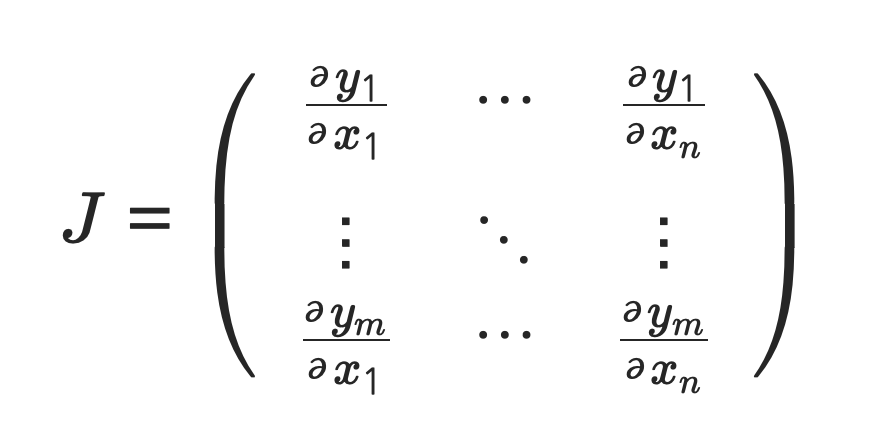
  야코비안 행렬 자체를 계산하는 대신, PyTorch는 주어진 입력 벡터 
v
=
(
v
1
…
v
m
)
v=(v 
1
​	
 …v 
m
​	
 )에 대한 야코비안 곱(Jacobian Product) 
v
T
⋅
J
v 
T
 ⋅J을 계산합니다. 이 과정은 
v
v를 인자로 backward를 호출하면 이뤄집니다. 
v
v의 크기는 곱(product)을 계산하려고 하는 원래 텐서의 크기와 같아야 합니다.

In [53]:
inp = torch.eye(5, requires_grad=True)
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


동일한 인자로 backward를 두차례 호출하면 변화도 값이 달라집니다. 이는 역방향 전파를 수행할 때, PyTorch가 변화도를 누적(accumulate)해주기 때문입니다. 즉, 계산된 변화도의 값이 연산 그래프의 모든 잎(leaf) 노드의 grad 속성에 추가됩니다. 따라서 제대로 된 변화도를 계산하기 위해서는 grad 속성을 먼저 0으로 만들어야 합니다. 실제 학습 과정에서는 옵티마이저(optimizer)가 이 과정을 도와줍니다.

+<br>
이전에는 매개변수 없이 backward() 함수를 호출했습니다. 이는 본질적으로 backward(torch.tensor(1.0)) 을 호출하는 것과 동일하며, 신경망 훈련 중의 손실과 같은 스칼라-값 함수의 변화도를 계산하는 유용한 방법입니다.

#모델 매개변수 최적화하기

이제 모델과 데이터가 준비되었으니, 데이터에 매개변수를 최적화하여 모델을 학습하고, 검증하고, 테스트할 차례입니다. 모델을 학습하는 과정은 반복적인 과정을 거칩니다; (에폭(epoch)이라고 부르는) 각 반복 단계에서 모델은 출력을 추측하고, 추측과 정답 사이의 오류(손실(loss))를 계산하고, (이전 장에서 본 것처럼) 매개변수에 대한 오류의 도함수(derivative)를 수집한 뒤, 경사하강법을 사용하여 이 파라미터들을 최적화(optimize)합니다

##기본(Pre-requisite) 코드

이전 장인 Dataset과 DataLoader와 신경망 모델 구성하기에서 코드를 가져왔습니다.

In [54]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

##하이퍼파라미터(Hyperparameter)

하이퍼파라미터(Hyperparameter)는 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수입니다. 서로 다른 하이퍼파라미터 값은 모델 학습과 수렴율(convergence rate)에 영향을 미칠 수 있습니다. (하이퍼파라미터 튜닝(tuning)에 대해 더 알아보기)

학습 시에는 다음과 같은 하이퍼파라미터를 정의합니다:

*   에폭(epoch) 수 - 데이터셋을 반복하는 횟수
*   배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수
*   학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있습니다.


In [55]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

##최적화 단계(Optimization Loop)

하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화할 수 있습니다. 최적화 단계의 각 반복(iteration)을 에폭이라고 부릅니다.

하나의 에폭은 다음 두 부분으로 구성됩니다:

*   학습 단계(train loop) - 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴합니다.
*   검증/테스트 단계(validation/test loop) - 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복(iterate)합니다.

학습 단계(training loop)에서 일어나는 몇 가지 개념들을 간략히 살펴보겠습니다. 최적화 단계(optimization loop)를 보려면 전체 구현 부분으로 건너뛰시면 됩니다.





###손실 함수(loss function)



학습용 데이터를 제공하면, 학습되지 않은 신경망은 정답을 제공하지 않을 확률이 높습니다. 손실 함수(loss function)는 획득한 결과와 실제 값 사이의 틀린 정도(degree of dissimilarity)를 측정하며, 학습 중에 이 값을 최소화하려고 합니다. 주어진 데이터 샘플을 입력으로 계산한 예측과 정답(label)을 비교하여 손실(loss)을 계산합니다.

일반적인 손실함수에는 회귀 문제(regression task)에 사용하는 nn.MSELoss(평균 제곱 오차(MSE; Mean Square Error))나 분류(classification)에 사용하는 nn.NLLLoss (음의 로그 우도(Negative Log Likelihood)), 그리고 nn.LogSoftmax와 nn.NLLLoss를 합친 nn.CrossEntropyLoss 등이 있습니다.

모델의 출력 로짓(logit)을 nn.CrossEntropyLoss에 전달하여 로짓(logit)을 정규화하고 예측 오류를 계산합니다.

###옵티마이저(Optimizer)

최적화는 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정입니다. 최적화 알고리즘은 이 과정이 수행되는 방식(여기에서는 확률적 경사하강법(SGD; Stochastic Gradient Descent))을 정의합니다. 모든 최적화 절차(logic)는 optimizer 객체에 캡슐화(encapsulate)됩니다. 여기서는 SGD 옵티마이저를 사용하고 있으며, PyTorch에는 ADAM이나 RMSProp과 같은 다른 종류의 모델과 데이터에서 더 잘 동작하는 다양한 옵티마이저가 있습니다.

학습하려는 모델의 매개변수와 학습률(learning rate) 하이퍼파라미터를 등록하여 옵티마이저를 초기화합니다.

In [56]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

학습 단계(loop)에서 최적화는 세단계로 이뤄집니다:

*   optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정합니다. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정합니다.
*   loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파합니다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장합니다.
*   변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정합니다.



##전체 구현

최적화 코드를 반복하여 수행하는 train_loop와 테스트 데이터로 모델의 성능을 측정하는 test_loop를 정의하였습니다

In [57]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

손실 함수와 옵티마이저를 초기화하고 train_loop와 test_loop에 전달합니다. 모델의 성능 향상을 알아보기 위해 자유롭게 에폭(epoch) 수를 증가시켜 볼 수 있습니다.

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306801  [    0/60000]
loss: 2.296075  [ 6400/60000]
loss: 2.272196  [12800/60000]
loss: 2.265675  [19200/60000]
loss: 2.258814  [25600/60000]
loss: 2.222042  [32000/60000]
loss: 2.232062  [38400/60000]
loss: 2.191260  [44800/60000]
loss: 2.196232  [51200/60000]
loss: 2.171895  [57600/60000]
Test Error: 
 Accuracy: 39.4%, Avg loss: 2.159719 

Epoch 2
-------------------------------
loss: 2.172950  [    0/60000]
loss: 2.166881  [ 6400/60000]
loss: 2.107085  [12800/60000]
loss: 2.128465  [19200/60000]
loss: 2.083286  [25600/60000]
loss: 2.021250  [32000/60000]
loss: 2.055634  [38400/60000]
loss: 1.970539  [44800/60000]
loss: 1.981637  [51200/60000]
loss: 1.919538  [57600/60000]
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.906588 

Epoch 3
-------------------------------
loss: 1.945374  [    0/60000]
loss: 1.917088  [ 6400/60000]
loss: 1.796118  [12800/60000]
loss: 1.843903  [19200/60000]
loss: 1.731930  [25600/60000]
loss: 1.678712  [32000/600

# 모델 저장하고 불러오기

이번 장에서는 저장하기나 불러오기를 통해 모델의 상태를 유지(persist)하고 모델의 예측을 실행하는 방법을 알아보겠습니다.

In [59]:
import torch
import torchvision.models as models

##모델 가중치 저장하고 불러오기

PyTorch 모델은 학습한 매개변수를 state_dict라고 불리는 내부 상태 사전(internal state dictionary)에 저장합니다. 이 상태 값들은 torch.save 메소드를 사용하여 저장(persist)할 수 있습니다:

In [60]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

모델 가중치를 불러오기 위해서는, 먼저 동일한 모델의 인스턴스(instance)를 생성한 다음에 load_state_dict() 메소드를 사용하여 매개변수들을 불러옵니다.

In [61]:
model = models.vgg16() # 기본 가중치를 불러오지 않으므로 pretrained=True를 지정하지 않습니다.
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

+<br>
추론(inference)을 하기 전에 model.eval() 메소드를 호출하여 드롭아웃(dropout)과 배치 정규화(batch normalization)를 평가 모드(evaluation mode)로 설정해야 합니다. 그렇지 않으면 일관성 없는 추론 결과가 생성됩니다.

##모델의 형태를 포함하여 저장하고 불러오기

모델의 가중치를 불러올 때, 신경망의 구조를 정의하기 위해 모델 클래스를 먼저 생성(instantiate)해야 했습니다. 이 클래스의 구조를 모델과 함께 저장하고 싶으면, (model.state_dict()가 아닌) model 을 저장 함수에 전달합니다:

In [62]:
torch.save(model, 'model.pth')

다음과 같이 모델을 불러올 수 있습니다:

In [63]:
model = torch.load('model.pth')

+<br>
이 접근 방식은 Python pickle 모듈을 사용하여 모델을 직렬화(serialize)하므로, 모델을 불러올 때 실제 클래스 정의(definition)를 적용(rely on)합니다.